# Explanation

For further background, consult [csnsquantile](csnsquantile) for the non-importance-weighted version of this technique.

For a real-valued discrete-time random process $X_t$ and non-negative discrete-time random process $W_t$ with $\forall t: 1 = \mathbb{E}_{t-1}\left[W_t\right]$, the code below constructs a confidence sequence for the CDF of the average historical conditional distribution, $$
\begin{aligned}
\overline{\text{CDF}}_t(v) &\doteq \frac{1}{t} \sum_{s \leq t} \mathbb{E}_{s-1}\left[W_s 1_{X_s \leq v}\right],
\end{aligned}
$$
which is simultaneously valid for all times and all values.  

A novel aspect relative to the non-importance-weighted case is whether or not the importance weights have infinite variance.  In this notebook the construction reduces to a pointwise [DDRM](https://arxiv.org/abs/2210.11133) bound, which can adapt to an unknown bounded moment $q \in (1, 2]$.  In [csnsquantile-ebern](csnsquantile-bern) these simulations are repeated but using [empirical Bernstein](https://arxiv.org/abs/1810.08240) as the pointwise bound, which only converges when the importance weights have finite variance, but is approximately 20x faster to compute.

# Derivation

## Step 1: Test supermartingale for $W_t 1_{X_t \leq v}$.

This is the Heavy NSM from [Mineiro](https://arxiv.org/abs/2210.11133) combined with an Adagrad $L^*$ bound and the DDRM mixture. This allows us to handle importance weights with unbounded variance.

For fixed $v$, let $Y_t = W_t 1_{X_t \geq v}$ be a non-negative real-valued discrete-time random process, let $\hat{Y}_t \in [0, 1]$ be a predictable sequence, and let $\lambda \in [0, 1)$ be a fixed scalar bet.  Then $$
\begin{aligned}
E_t(\lambda) &\doteq \exp\left( \lambda \left(\sum_{s \leq t} \hat{Y}_s - \mathbb{E}_{s-1}\left[Y_s\right]\right) + \sum_{s \leq t} \log\left(1 + \lambda \left(Y_s - \hat{Y}_s\right) \right) \right) \\
&= \exp\left( \lambda \left(\sum_{s \leq t} Y_s - \mathbb{E}_{s-1}\left[Y_s\right]\right) - \sum_{s \leq t} \underbrace{\left( \lambda \left(Y_s - \hat{Y}_s\right) - \log\left(1 + \lambda \left(Y_s - \hat{Y}_s\right) \right) \right)}_{\doteq h\left(\lambda \left(Y_s - \hat{Y}_s\right)\right)} \right) \\
&= \exp\left( \lambda \left(\sum_{s \leq t} Y_s - \mathbb{E}_{s-1}\left[Y_s\right]\right) - \sum_{s \leq t} h\left(\lambda \left(Y_s - \hat{Y}_s\right)\right) \right) \\
&\geq \exp\left( \lambda \left(\sum_{s \leq t} Y_s - \mathbb{E}_{s-1}\left[Y_s\right]\right) - \left( \sum_{s \leq t} h\left(\lambda \left(Y_s - \hat{Y}_t^*\right)\right) \right) - \text{Reg}(t) \right) & \left(\dagger\right) \\
&= \exp\left( \lambda \left(t \hat{Y}_t^* - \sum_{s \leq t} \mathbb{E}_{s-1}\left[Y_s\right]\right) + \sum_{s \leq t} \log\left(1 + \lambda \left(Y_s - \hat{Y}_t^*\right) \right) - \text{Reg}(t) \right),
\end{aligned}
$$ where for $(\dagger)$ we use a no-regret learner on $h()$ with regret $\text{Reg}(t)$ to any constant prediction $\hat{Y}_t^* \in [0, 1]$.  The function $h()$ is $M$-smooth with $M = \frac{\lambda^2}{(1 - \lambda)^2}$ (see [Lemma 9](https://web.stanford.edu/~sidford/courses/20fa_opt_theory/sidford_mse213_2020fa_chap_5_extensions.pdf)) so we can get an [L^* bound](https://parameterfree.com/2019/09/20/adaptive-algorithms-l-bounds-and-adagrad/) of $$
\begin{aligned}
\text{Reg}(t) &= 4 \frac{\lambda^2}{(1 - \lambda)^2} + 4 \frac{\lambda}{1 - \lambda} \sqrt{\sum_{s \leq t} h\left(\lambda \left(Y_s - \hat{Y}_t^*\right)\right)} \\
&= 4 \frac{\lambda^2}{(1 - \lambda)^2} + 4 \frac{\lambda}{1 - \lambda} \sqrt{\left(-t \hat{Y}_t^* + \sum_{s \leq t} Y_s\right) - \sum_{s \leq t} \log\left(1 + \lambda \left(Y_s - \hat{Y}_t^*\right)\right)} \\
\end{aligned}
$$ thus essentially our variance process is inflated by a square-root.

We can compete with any in-hindsight prediction, if we choose to compete with the clipped running mean $\overline{Y_t}$ then we end up with $$
\begin{aligned}
E_t(\lambda) &\geq \exp\left( \lambda \left(\min\left(t, \sum_{s \leq t} Y_s\right) - \mathbb{E}_{s-1}\left[Y_s\right]\right) + \sum_{s \leq t} \log\left(1 + \lambda \left(Y_s - \overline{Y_t}\right) \right)  - \text{Reg}(t) \right),
\end{aligned}
$$ and furthermore $$
\begin{aligned}
\sum_{s \leq t} \log\left(1 + \lambda \left(Y_s - \overline{Y_t}\right) \right) &\leq \lambda \left(\sum_{s \leq t} Y_s - t \overline{Y_t}\right)
\end{aligned}
$$ which is useful for early terminating discrete mixtures.  To minimize computational overhead, we can lower bound $\log(a + b)$ for $b \geq 0$ using strong concavity, $$
\begin{aligned}
(1 + k)^{n_l} = z_l &\leq z < z_u = (1 + k) z_l = (1 + k)^{n_l+1}, \\
f(z) &\doteq \log\left(1 + \lambda \left(z - \hat{Y}_t^*\right) \right), \\
f(z) &\geq \alpha f(z_l) + (1 - \alpha) f(z_u) + \frac{1}{2} \alpha (1 - \alpha) m(z_l), \\
\alpha &\doteq \frac{z_u - z}{z_u - z_l}, \\
m(z_l) &\doteq \left( \frac{k z_l \lambda}{k z_l \lambda + 1 - \lambda \hat{Y}_t^*} \right)^2.
\end{aligned}
$$


## Step 2: Use a countably infinite collection of intervals

The $n$-th intervals models $\sum_{s \leq t} \mathbb{E}_{s-1}\left[1_{X_s \leq u(n)}\right]$ via the test supermartingale.  Let $\alpha(n) \geq 0$ define a (decreasing) assignment of probability with $1 \geq \sum_{n=1}^\infty \alpha(n)$ for a union bound, e.g., $\alpha(n) = 6 / (\pi^2 n^2)$.

Although we have a countable infinite number of intervals covered with a union bound, there is no point in evaluating past the point where the bounds can improve.  Specifically, if all counts are to the left of the probe, there is no point in further refining the upper boundary.

# Code

In [1]:
class LogApprox(object):
    def __init__(self, k):
        from math import sqrt
        from numbers import Number

        super().__init__()
        
        assert isinstance(k, Number), k
        assert 0 < k < 1
        
        self.k = k
        self.stats = {}
        self.sumz = 0
        self.tot = 0
                
    def __le__(self, other):
        if self.k != other.k:
            raise NotImplementedError
            
        return self.sumz <= other.sumz
            
    def __iadd__(self, other):
        if self.k != other.k:
            raise NotImplementedError
        
        for k, v in other.stats.items():
            self.stats.setdefault(k, 0)
            self.stats[k] += v
            
        self.sumz += other.sumz
        self.tot += other.tot
        
        return self
    
    def __add__(self, other):
        import copy
        rv = copy.deepcopy(self)
        rv += other
        return rv

    def sumy(self):
        return self.sumz
    
    def yhat(self):
        return 0 if self.tot == 0 else min(1, self.sumz / self.tot)

    def getLowerBoundWithRegret(self, lam):
        from math import log1p, sqrt, inf
        
        assert 0 < lam < 1
        
        rv = 0
        yhat = self.yhat()
        hemp = 0
        
        for (what, z), v in self.stats.items():
            assert what == 'f' or what == 'm'
            if what == 'f':
                dalog = log1p(lam * (z - yhat))
                rv += v * dalog
                hemp += v * (lam * (z - yhat) - dalog)
            elif what == 'm':
                rv += v * ( (self.k * z * lam) / (self.k * z * lam + 1 - lam * yhat) )**2
                
        lstarregret = 4 * lam**2 / (1 - lam)**2 + 4 * lam / (1 - lam) * sqrt(hemp)
            
        return rv - lstarregret
        
    def update(self, z, c):
        from numbers import Number
        assert isinstance(z, Number), z
        assert z >= 0
        assert isinstance(c, Number), c
        assert c >= 0
        
        # TODO: Kahan summation
        if z == 0:
            self.stats.setdefault(('f', z), 0)
            self.stats[('f', z)] += c
        else:
            from math import log, log1p, floor
            n = floor(log(z) / log1p(self.k))
            zl = (1 + self.k)**n
            zu = (1 + self.k)**(n+1)
            alpha = (zu - z) / (zu - zl)
            if alpha > 0:
                self.stats.setdefault(('f', zl), 0)
                self.stats[('f', zl)] += alpha * c
            if alpha < 1:
                self.stats.setdefault(('f', zu), 0)
                self.stats[('f', zu)] += (1 - alpha) * c
            if alpha > 0 and alpha < 1:
                self.stats.setdefault(('m', zl), 0)
                self.stats[('m', zl)] += alpha * (1 - alpha) * c
            
        self.sumz += c * z
        self.tot += c
                                
        return self

class DDRM(object):
    def __init__(self, *, eta=0.95, r=2, lambdamax=1/2, xi=8/5):
        from math import exp
        from mpmath import fp 
        from scipy.special import lambertw
        
        super().__init__()
        
        assert 0 < eta < 1
        assert 1 < r
        assert 0 < lambdamax <= 1 + lambertw(-exp(-2))
        assert 1 < xi
        
        self.eta = eta
        self.r = r
        self.lambdamax = lambdamax
        self.xi = xi
        self.scalefac = 1/2 * (xi - 1) * (1 + fp.polylog(r, eta) / (eta * fp.zeta(r)))
    
    def get_lam(self, j):
        return self.lambdamax / self.xi**(1/2 + j)

    def get_w(self, j):
        return self.scalefac / self.xi**(1 + j)
    
    def get_remaining_w_ub(self, j):
        # Sum[scale / \[Xi]^(1+k), { k, j + 1, Infinity }]
        return self.scalefac * (self.xi - 1) / self.xi**(1 + j)
    
class StreamingDDRMECDF(object):
    class Frozen(object):
        def __init__(self, *, rawsd, k, tot, negated):
            from sortedcontainers import SortedDict
            super().__init__()
        
            self.sd = SortedDict()
            zeros = tot
            
            cumsum = LogApprox(k)
            keys = rawsd.__reversed__() if negated else rawsd.keys()
            for z in keys:
                v = rawsd[z]
                cumsum += v
                zeros -= v.tot
                newz = -z if negated else z
                self.sd[newz] = cumsum + LogApprox(k).update(0, zeros)
                
            assert zeros == 0
            self.cumsum = cumsum
            self.tot = tot

        def __call__(self, H):
            if H is None:
                return self.tot
            
            hgeindex = self.sd.bisect_right(H)
            if hgeindex != len(self.sd):
                _, Hcnt = self.sd.peekitem(hgeindex)
            else:
                Hcnt = self.cumsum
                
            return Hcnt

    def __init__(self, *, k):
        from numbers import Number

        assert isinstance(k, Number), k
        assert k > 0
        
        from sortedcontainers import SortedDict
        super().__init__()
        
        self.sd = SortedDict()
        self.k = k
        self.tot = 0
        
    def addobs(self, r, w):
        from numbers import Number
        assert isinstance(r, Number), r
        assert isinstance(w, Number), w
        assert w >= 0
        
        if r not in self.sd:
            self.sd[r] = LogApprox(self.k)
        self.sd[r].update(w, 1)
        self.tot += 1
        
    def freeze(self):
        return self.Frozen(rawsd=self.sd, k=self.k, tot=self.tot, negated=False)
    
    def minusfreeze(self):
        return self.Frozen(rawsd=self.sd, k=self.k, tot=self.tot, negated=True)

In [2]:
def getDDRMCSLowerBound(logapprox, t, logp):
    from scipy.optimize import root_scalar
    
    assert t >= 1
    assert t == logapprox.tot
    muhat = logapprox.yhat()
    thres = -logp
    ddrm = DDRM()
    lams = [ ddrm.get_lam(j) for j in range(2) ]
    vs = [ logapprox.getLowerBoundWithRegret(lam) for lam in lams ]
    ws = [ ddrm.get_w(j) for j, _ in enumerate(lams) ]
    ubvar = logapprox.sumy() - t * muhat

    def logwealth(mu):
        from scipy.special import logsumexp
        nonlocal lams
        nonlocal vs
        nonlocal ws
        
        a = [ lamj * t * (muhat - mu) + vj
              for lamj, vj in zip(lams, vs)
            ] 
        
        while True:
            logwlb = logsumexp(a=a, b=ws)

            # lower bound
            if logwlb >= thres:
                assert True, {
                    'a': a,
                    'ws': ws, 
                    'logwlb': logwlb, 
                    'thres': thres, 
                    'muhat': muhat,
                    'mu': mu,
                    't': t,
                }
                return logwlb
            
            # upper bound
            j = len(lams)
            logwub = logsumexp(a = [lams[-1] * t * (muhat - mu) + lams[-1] * ubvar] + a,
                               b = [ddrm.get_remaining_w_ub(j)] + ws)
            if logwub <= thres:
                assert True, {
                    'logwub': logwub, 
                    'thres': thres, 
                    'ws': ws, 
                    'muhat': muhat,
                    'mu': mu,
                    'lams[-1] * t * (muhat - mu)': lams[-1] * t * (muhat - mu),
                    'wub': ddrm.get_remaining_w_ub(j),
                }
                return logwub
            
            lams += [ ddrm.get_lam(j) ]
            vs += [ logapprox.getLowerBoundWithRegret(lams[-1]) ]
            ws += [ ddrm.get_w(j) ]
            a += [ lams[-1] * t * (muhat - mu) + vs[-1] ]
    
    mumin = 0
    mumax = min(1, logapprox.sumy()/t)
    if mumax <= mumin or logwealth(mumin) <= thres:
        return mumin
    
    if logwealth(mumax) >= thres:
        return mumax
    
    res = root_scalar(f=lambda mu: logwealth(mu) - thres, bracket=[mumin, mumax], xtol=max(1e-6, 1/(2*t)))
    assert res.converged
    return res.root

def getUnifLowerBound(probe, counts, conf):
    from math import log, floor, pi
    
    lb = 0

    log6opsq = log(6/pi**2)
    logconf = log(conf)
    
    t = counts(None)
    cprobe = counts(probe)

    # technically depth range(1, infinity)
    # in practice we have finite numerical precision
    for depth in range(1, 100):
        # grid is (k / 2**depth) for k in [0, \ldots, (2**depth)-1]
        # even values of k are duplicates from prior grids
        # hence size of grid not already covered is 2**(depth-1)
        
        logp = log6opsq - 2 * log(depth) - (depth - 1) * log(2)
        #                 ^--- union bound over depth
        #                                   ^--- shared by 2^(depth-1) 
        
        klower = floor(2**depth * probe)
        if klower % 2 == 1:
            vlower = klower / 2**depth
            assert vlower <= probe
            clower = counts(vlower) 
            lb = max(lb, getDDRMCSLowerBound(clower, t, logp + logconf))
            if clower >= cprobe:
                break
            
    return lb

def getGenericLowerBound(probe, *, counts, conf, refcdf, refppf):
    return getUnifLowerBound(refcdf(probe), lambda h: counts(None) if h is None else counts(refppf(h)), conf)

def getGenericUpperBound(probe, *, minuscounts, conf, refsf, refisf):
    # CDF(X; v) = P(X <= v)
    # CDF(-X; -v) = P(-X <= -v) = P(X > v) 
    return 1 - getUnifLowerBound(refsf(probe), lambda h: minuscounts(None) if h is None else minuscounts(-refisf(h)), conf)

# IID Examples
In the examples below, a time-uniform version of [DKW](https://en.wikipedia.org/wiki/Dvoretzky%E2%80%93Kiefer%E2%80%93Wolfowitz_inequality) is shown as a baseline just to get an idea of the empirical performance of the technique.  Note DKW does not hold for general data dependent generation.

In [3]:
def plotit(data, ws, true, ref, extra=[], titles=[None]*3, files=[None]*3, compare=[], hacks=[None]*3):
    from math import sqrt, log, pi
    from scipy.interpolate import interp1d
    from tqdm.notebook import tqdm
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mticker
    import numpy as np
    import time
    
    f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
    g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
    fmt = mticker.FuncFormatter(g)
    
    linestyle_tuple = [
        ('solid', 'solid'),      # Same as (0, ()) or '-'
        ('dotted', 'dotted'),    # Same as (0, (1, 1)) or ':'
        ('dashed', 'dashed'),    # Same as '--'
        ('dashdot', 'dashdot'),  # Same as '-.'
        #('loosely dotted',        (0, (1, 10))),
        #('dotted',                (0, (1, 1))),
        #('densely dotted',        (0, (1, 1))),
        ('long dash with offset', (5, (10, 3))),
        ('loosely dashed',        (0, (5, 10))),
        ('dashed',                (0, (5, 5))),
        ('densely dashed',        (0, (5, 1))),

        ('loosely dashdotted',    (0, (3, 10, 1, 10))),
        ('dashdotted',            (0, (3, 5, 1, 5))),
        ('densely dashdotted',    (0, (3, 1, 1, 1))),

        ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
        ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
        ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))
    ]
    megalw = 3
    megafs = 20
    
    conf = 0.05
    
    T = len(data)    
    nxvals = 1000

    ecdfx = np.sort(data)
    ecdfy = np.arange(1, len(data)+1)/float(len(data))
    probevals = np.interp(x=np.linspace(0.001, 0.999, nxvals), xp=ecdfy, fp=ecdfx, left=0, right=1)
    ecdff = interp1d(x=ecdfx, y=ecdfy, fill_value=(0, 1), kind='previous', bounds_error=False)
    ecdffunc = np.array([ ecdff(v) for v in probevals ])

    exactcdfy = np.array([ true.cdf(x) for x in probevals ])
    
    plt.figure()
    plt.gcf().set_size_inches(16, 8)
    plt.plot(probevals, ecdffunc - exactcdfy, label='empirical minus exact cdf')
    
    counts = StreamingDDRMECDF(k=0.25)
    for r, w in zip(data, ws):
        counts.addobs(r, w)     
    icey = counts.freeze()
    minusicey = counts.minusfreeze()
    lbcdfy = np.array([ getGenericLowerBound(x, counts = icey, conf = conf / 2, refcdf = ref.cdf, refppf = ref.ppf) for x in probevals ])
    start = time.time()
    ubcdfy = np.array([ getGenericUpperBound(x, minuscounts = minusicey, conf = conf / 2, refsf = ref.sf, refisf = ref.isf) for x in probevals ])
    end = time.time()
    print(f'ubcdfy calc time: {end-start:.3g}')

    plt.plot(probevals, ubcdfy - exactcdfy, label='cdf ub minus exact')
    plt.plot(probevals, exactcdfy - lbcdfy, label='cdf exact minus lb')
    plt.title(titles[0] or 'difference between bounds and exact CDF')
    plt.legend()
    if files[0]:
        plt.savefig(files[0], bbox_inches='tight')
    
    # DKW
    logtuconf = log(conf) + log(6/pi**2) - 2*log(T)
    dkwtueps = sqrt((log(2) - logtuconf) / (2 * T))
    plt.figure()
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 8)
    ax.tick_params(labelsize=megafs+2)
    plt.style.use('seaborn-deep')
    plt.plot(probevals, ubcdfy - lbcdfy, color=f'C1', label=f'{true.desc}')
    minprobevals, maxprobevals = min(probevals), max(probevals)
    for n, t in tqdm(list(enumerate(compare)), desc='compare', leave=False):
        counts = StreamingDDRMECDF(k=0.25)
        for r, w in zip(t.data, ws):
            counts.addobs(r, w)  
        icey = counts.freeze()
        minusicey = counts.minusfreeze()
        compecdfx = np.sort(t.data)
        compecdfy = np.arange(1, len(t.data)+1)/float(len(t.data))
        compprobevals = np.interp(x=np.linspace(0.001, 0.999, nxvals), xp=compecdfy, fp=compecdfx, left=0, right=1)
        complbcdfy = np.array([ getGenericLowerBound(x, counts = icey, conf = conf / 2, refcdf = ref.cdf, refppf = ref.ppf) for x in compprobevals ])
        compubcdfy = np.array([ getGenericUpperBound(x, minuscounts = minusicey, conf = conf / 2, refsf = ref.sf, refisf = ref.isf) for x in compprobevals ])
        plt.plot(compprobevals, compubcdfy - complbcdfy, color=f'C{n+2}', label=f'{t.desc}')
        minprobevals, maxprobevals = min(minprobevals, min(compprobevals)), max(maxprobevals, max(compprobevals))
    #plt.plot([minprobevals, maxprobevals], [2*dkwtueps]*2, color=f'C0', linestyle='dashed', label=f'Time uniform DKW')
    ax.set_xlabel(f'$v$', fontsize=megafs+2)
    ax.set_ylabel('$U_t(v) - L_t(v)$', fontsize=megafs+4)
    ax.legend(fontsize=megafs).get_frame().set_linewidth(megalw)
    for x in ax.spines.values():
        x.set_linewidth(megalw)
    plt.title(titles[1] or f'bound widths for $T=${fmt(T)} draws from {true.desc}', fontsize=megafs+6)
    if hacks[1]:
        hacks[1](fig, ax)
    if files[1]:
        plt.savefig(files[1], bbox_inches='tight')
    
    plt.figure()
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 8)
    ax.tick_params(labelsize=megafs+2)
    plt.style.use('seaborn-deep')
    plt.plot(probevals, exactcdfy, label='true cdf', color=f'C0', linestyle=linestyle_tuple[0][1], linewidth=megalw)
    for n, t in tqdm(list(enumerate(extra)), desc='extra', leave=False):
        counts = StreamingDDRMECDF(k=0.25)
        for r, w in zip(data[:t], ws[:t]):
            counts.addobs(r, w)
        icey = counts.freeze()
        minusicey = counts.minusfreeze()
        extralbcdfy = np.array([ getGenericLowerBound(x, counts = icey, conf = conf / 2, refcdf = ref.cdf, refppf = ref.ppf) for x in probevals ])
        extraubcdfy = np.array([ getGenericUpperBound(x, minuscounts = minusicey, conf = conf / 2, refsf = ref.sf, refisf = ref.isf) for x in probevals ])
        plt.plot(probevals, extralbcdfy, label=f'$t=${fmt(t)}', color=f'C{n+2}', linestyle=linestyle_tuple[n+2][1], linewidth=megalw)
        plt.plot(probevals, extraubcdfy, label=None, color=f'C{n+2}', linestyle=linestyle_tuple[n+2][1], linewidth=megalw)
    plt.plot(probevals, lbcdfy, label=f'$t=${fmt(T)}', color=f'C1', linestyle=linestyle_tuple[1][1], linewidth=megalw)
    plt.plot(probevals, ubcdfy, label=None, color=f'C1', linestyle=linestyle_tuple[1][1], linewidth=megalw)
    ax.set_xlabel(f'$v$', fontsize=megafs+2)
    ax.set_ylabel('$\\overline{CDF}_t(v)$', fontsize=megafs+4)
    ax.legend(fontsize=megafs).get_frame().set_linewidth(megalw)
    for x in ax.spines.values():
        x.set_linewidth(megalw)
    plt.title(titles[2] or f'ubcdf calc time for $T=${fmt(T)} at {nxvals} evenly spaced x-values: {end-start:.3f} s', fontsize=megafs+6)
    if hacks[2]:
        hacks[2](fig, ax)
    if files[2]:
        plt.savefig(files[2], bbox_inches='tight')

### Beta(6,3) reward distribution, Exp(1) weight distribution
Using the uniform$([0,1])$ distribution as reference (reward) measure.  The importance weights are unbounded but finite variance.

ubcdfy calc time: 24.8


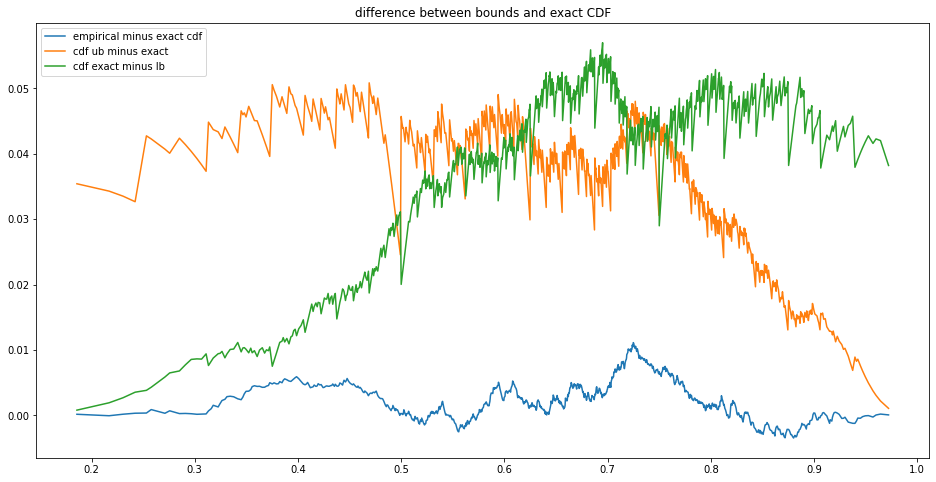

<Figure size 432x288 with 0 Axes>

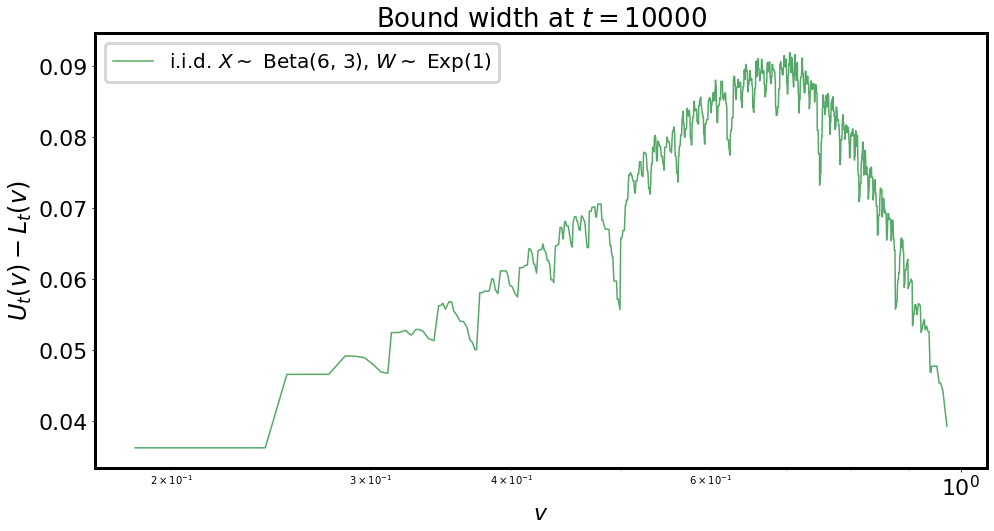

<Figure size 432x288 with 0 Axes>

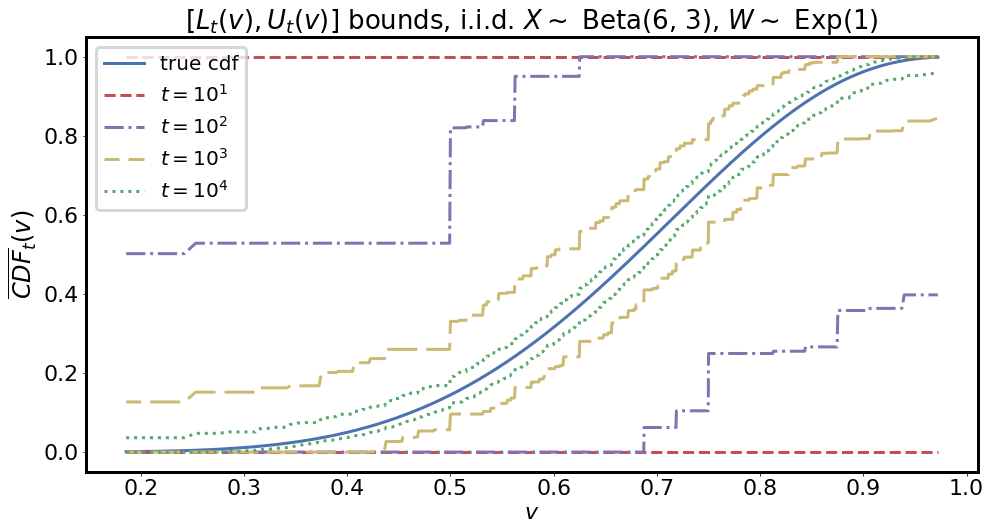

In [4]:
def flass(seed=4546):
    from scipy.special import betainc
    from numpy.random import default_rng

    betaa, betab = 6, 3
    T = 10000
    
    rng = default_rng(seed)
    data = rng.beta(betaa, betab, size=T)
    ws = rng.exponential(scale=1, size=T)
    
    Anon = lambda **kwargs: type("Object", (), kwargs)()
    
    true = Anon(desc = f'i.i.d. $X \\sim$ Beta({betaa}, {betab}), $W \\sim $ Exp(1)',
                cdf = lambda slf, x: betainc(betaa, betab, x)
               )
        
    ref = Anon(cdf = lambda slf, x: x,
               ppf = lambda slf, x: x,
               sf = lambda slf, x: 1 - x,
               isf = lambda slf, x: 1 - x,
              )
        
    plotit(data, ws, true, ref, 
           extra=[10, 100, 1000], 
           titles=[None, 
                   f'Bound width at $t={T}$',
                   f'$[L_t(v), U_t(v)]$ bounds, {true.desc}'],
           files=[None, 'betaexpiwboundwidth.pdf', 'betaexpiwcurves.pdf'],
           compare=[
                    # Anon(desc = f'i.i.d. $X \\sim$ Beta({betaa}, {betab*mult}), $W \\sim $ Exp(1)',
                    #      data = rng.beta(betaa, betab*mult, size=T)
                    #     )
                    # for mult in (100, 10000,)
                   ],
           hacks=[None, lambda fig, ax: ax.set_xscale('log'), None ],
          )

flass()

### Beta(6,3) reward distribution, Pareto(3/2) weight distribution
Using the uniform$([0,1])$ distribution as reference (reward) measure.  The importance weights have unbounded variance.

ubcdfy calc time: 59.4


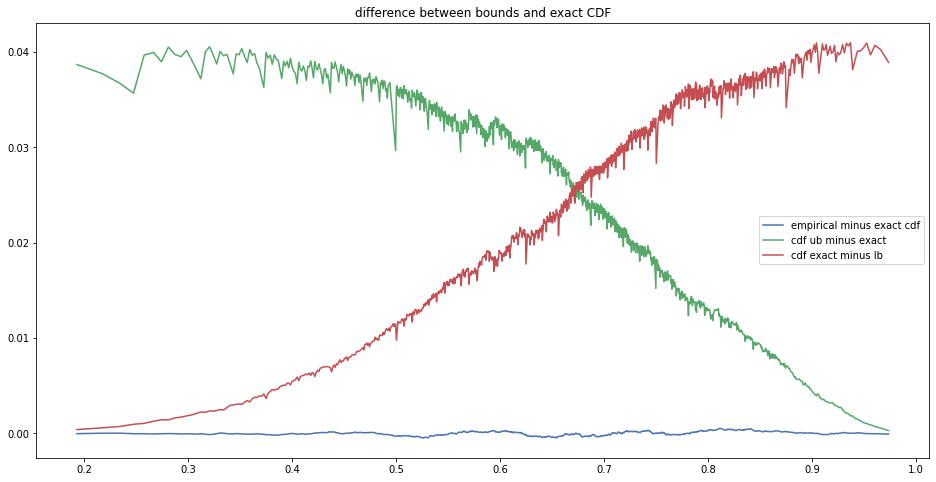

<Figure size 432x288 with 0 Axes>

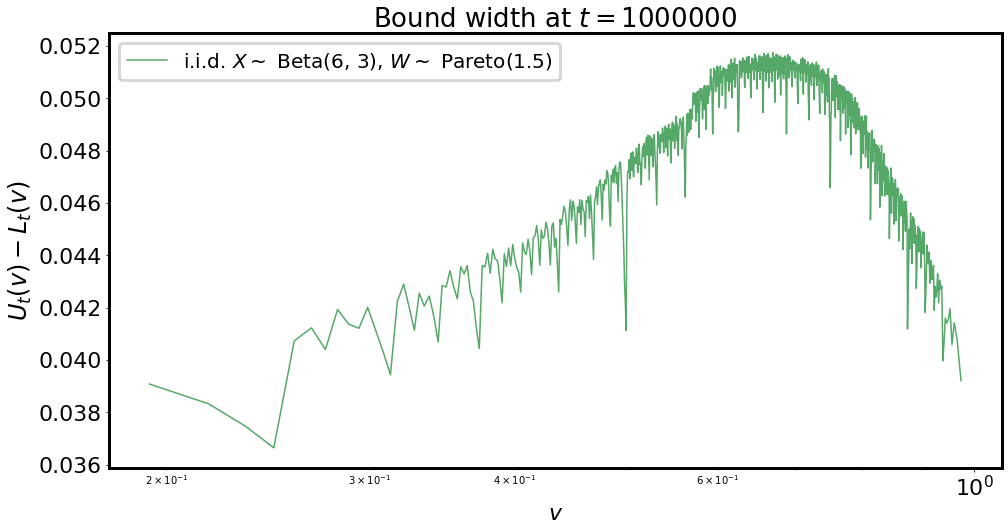

<Figure size 432x288 with 0 Axes>

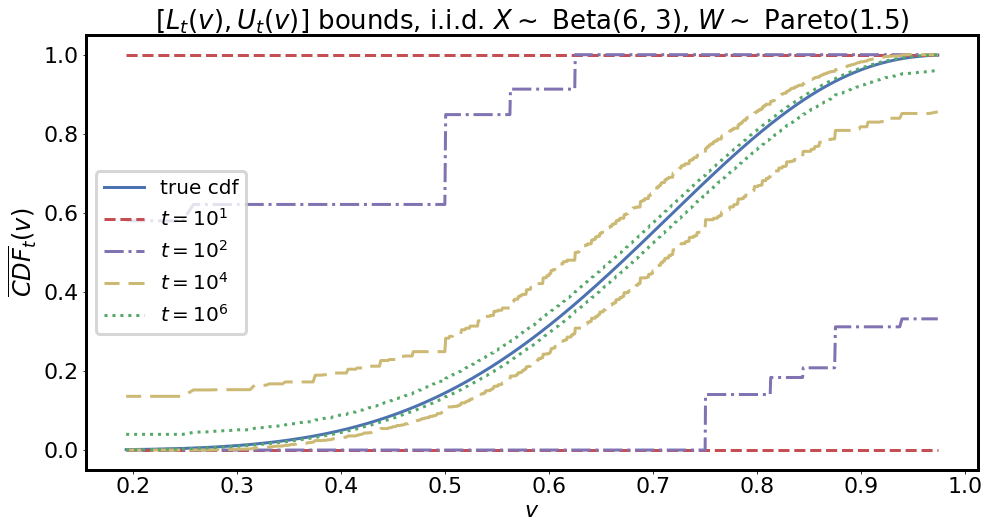

In [5]:
def flass(seed=4546):
    from scipy.special import betainc
    from numpy.random import default_rng

    betaa, betab = 6, 3
    paretoa = 3/2
    T = 1000000
    
    rng = default_rng(seed)
    data = rng.beta(betaa, betab, size=T)
    m = (paretoa - 1) / paretoa
    ws = (1 + rng.pareto(a=paretoa, size=T)) * m
    
    Anon = lambda **kwargs: type("Object", (), kwargs)()
    
    true = Anon(desc = f'i.i.d. $X \\sim$ Beta({betaa}, {betab}), $W \\sim $ Pareto({paretoa})',
                cdf = lambda slf, x: betainc(betaa, betab, x)
               )
        
    ref = Anon(cdf = lambda slf, x: x,
               ppf = lambda slf, x: x,
               sf = lambda slf, x: 1 - x,
               isf = lambda slf, x: 1 - x,
              )
        
    plotit(data, ws, true, ref, 
           extra=[10, 100, 10000, ], 
           titles=[None, 
                   f'Bound width at $t={T}$',
                   f'$[L_t(v), U_t(v)]$ bounds, {true.desc}'],
           files=[None, 'betaparetoiwboundwidth.pdf', 'betaparetoiwcurves.pdf'],
           compare=[
                    # Anon(desc = f'i.i.d. $X \\sim$ Beta({betaa}, {betab*mult}), $W \\sim $ Pareto({paretoa})',
                    #      data = rng.beta(betaa, betab*mult, size=T)
                    #     )
                    # for mult in (100, 10000,)
                   ],
           hacks=[None, lambda fig, ax: ax.set_xscale('log'), None ],
          )

flass()